In [160]:
# Fill in your names using the format below
your_name = "Hegde, Medha_Manjunath"

# Machine Learning Engineering - Assignment 2
The [Speed Dating dataset](https://www.openml.org/d/40536) collects feedback gathered from participants in experimental speed dating events. Every participant rated themselves and their dates according to different attributes (e.g. attractiveness, sincerity, intelligence, fun, ambition, and shared interests,...), and whether or not they were interested in a second date. Our goal is to build a machine learning model able to predict whether there will be a match (or not) between two different people. Will you be able to trust your final model?

In [161]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
start_time = time.time()

### Additional packages:
* Seaborn (plotting)
    - Run `pip install seaborn` or `conda install seaborn`
* tqdm (progress bar for longer running jobs)
    - Run `pip install tqdm`

In [162]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import seaborn as sns
from tqdm.notebook import tqdm
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated. Please update now! pip install -U scikit-learn")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [163]:
# Download Speed Dating data. Takes a while the first time. Do not change this code!
# Note that X is a pandas dataframe 
dates = openml.datasets.get_dataset(40536)
X, y, _, feat_names = dates.get_data(target=dates.default_target_attribute)

In [164]:
# Cleanup. Do not change this code!
# Remove irrelevant or preprocessed columns 
cols = [c for c in X.columns if ((c.lower()[:2] != 'd_' or c.lower() == 'd_age') and c.lower() not in ['wave','has_null'])]
X = X[cols]
classes = ['No match','Match']

# Fix feature name typos
X = X.rename(columns={'ambtition_important': 'ambition_important',
                     'sinsere_o': 'sincere_o'})

# Harmonize the field names somewhat
X['field'] = X['field'].str.lower()
X = X.astype({'field': 'category'})

# Drop columns with more than 10% missing values
missing_counts = X.isnull().sum() * 100 / len(X)
d = {k:v for (k,v) in missing_counts.items() if v>10}
X.drop(d.keys(), axis=1, inplace=True)

# Solves an implementation issue with TargetEncoder
y=y.astype(int)

In [165]:
# THIS WILL BE HELPFUL, but do not use these as global variables in your functions!
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [166]:
# Peek at the remaining data
X

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked,met
0,female,21.0,27.0,6.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.14,3.0,7.0,6.0,0.0
1,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.54,3.0,7.0,5.0,1.0
2,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.16,3.0,7.0,NaN,1.0
3,female,21.0,23.0,2.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.61,3.0,7.0,6.0,0.0
4,female,21.0,24.0,3.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.21,3.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,male,25.0,26.0,1.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.64,10.0,2.0,5.0,0.0
8374,male,25.0,24.0,1.0,European/Caucasian-American,Other,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.71,10.0,4.0,4.0,0.0
8375,male,25.0,29.0,4.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,-0.46,10.0,6.0,5.0,0.0
8376,male,25.0,22.0,3.0,European/Caucasian-American,Asian/Pacific Islander/Asian-American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.62,10.0,5.0,5.0,0.0


In [167]:
# Check the column data types and missing data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         8378 non-null   category
 1   age                            8283 non-null   float64 
 2   age_o                          8274 non-null   float64 
 3   d_age                          8378 non-null   float64 
 4   race                           8315 non-null   category
 5   race_o                         8305 non-null   category
 6   samerace                       8378 non-null   category
 7   importance_same_race           8299 non-null   float64 
 8   importance_same_religion       8299 non-null   float64 
 9   field                          8315 non-null   category
 10  pref_o_attractive              8289 non-null   float64 
 11  pref_o_sincere                 8289 non-null   float64 
 12  pref_o_intelligence            828

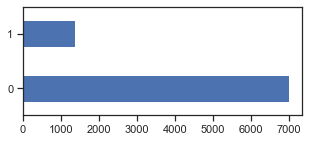

In [168]:
# Is the data balanced?
y.value_counts().plot(kind='barh', figsize=(5,2));

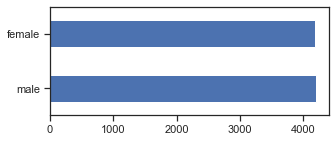

In [169]:
# See if some groups of people are more represented than others
X['gender'].value_counts().plot(kind='barh', figsize=(5,2));

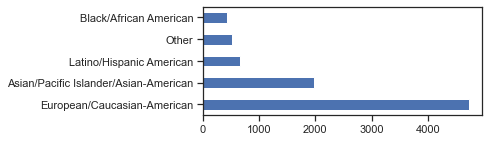

In [170]:
X['race'].value_counts().plot(kind='barh', figsize=(5,2));

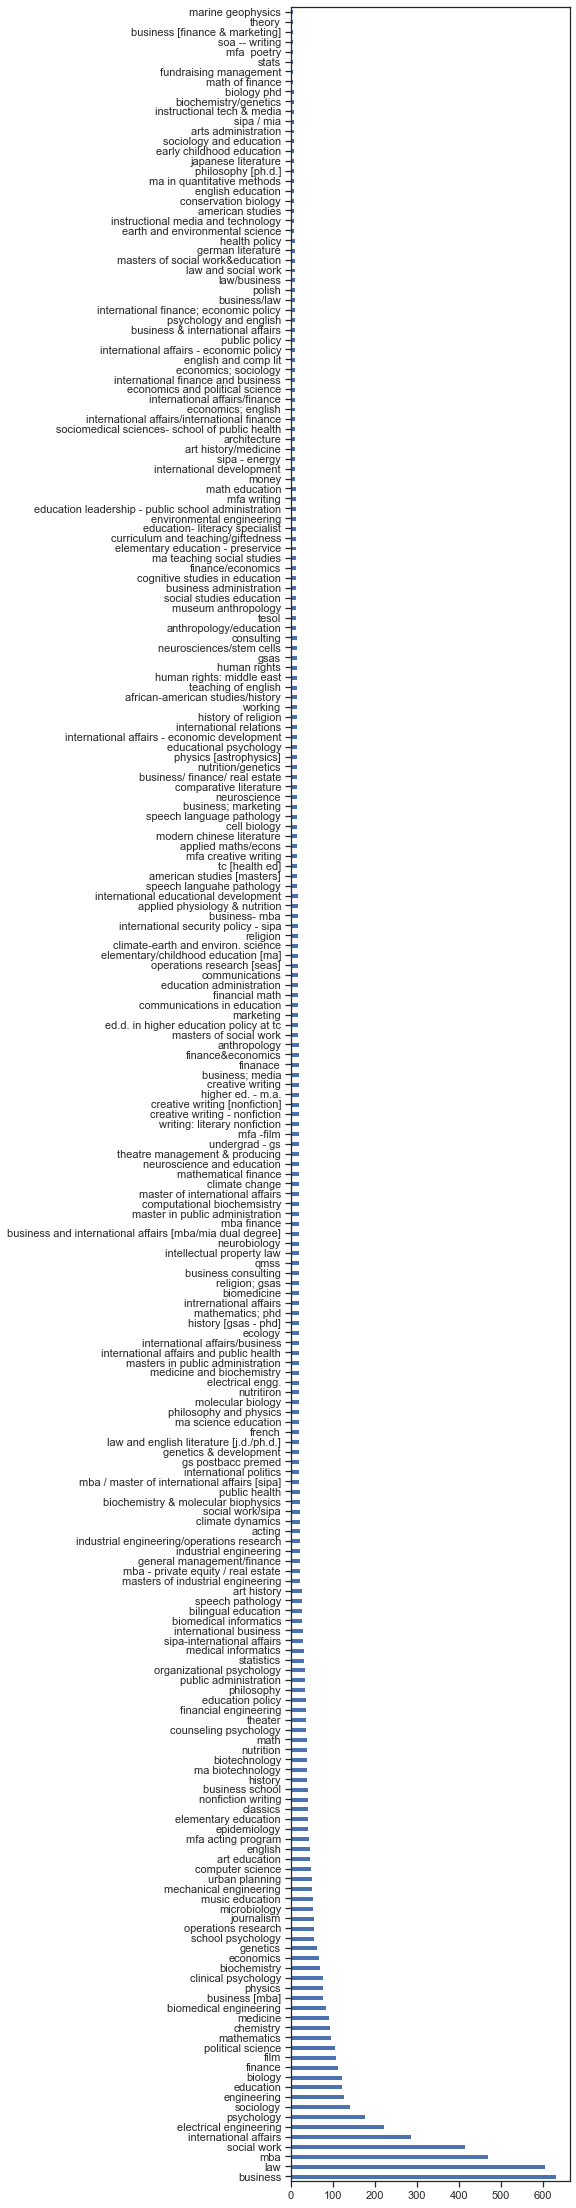

In [171]:
# Some categorical columns have a large number of possible values
# Some professions occur a lot more than others.
# Note: It looks like some manual cleaning should be done, but let's move on
X['field'].value_counts().plot(kind='barh', figsize=(5,40));

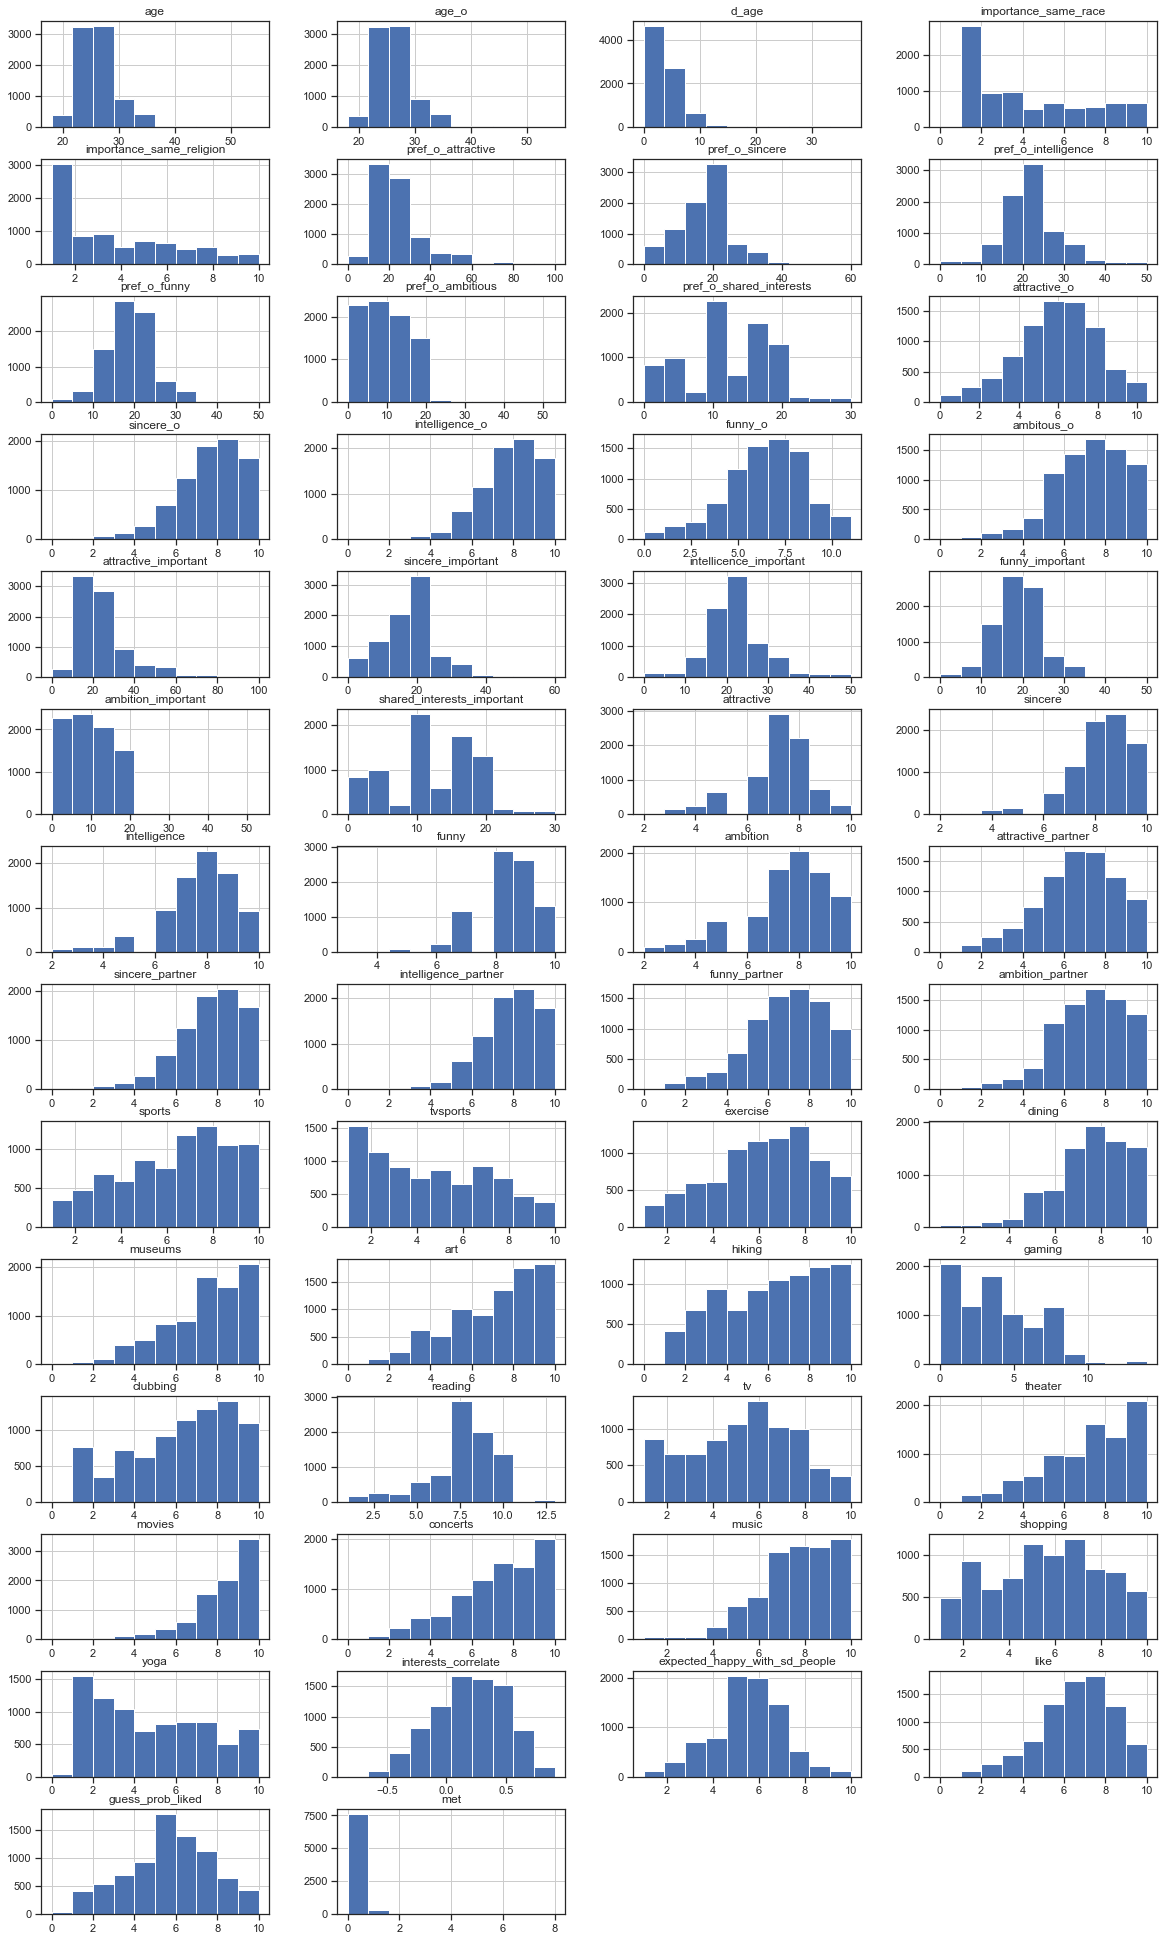

In [172]:
# Distributions of numeric data
# Some are normally distributed, others are very skewed.
X.hist(layout=(20,4), figsize=(20,50));

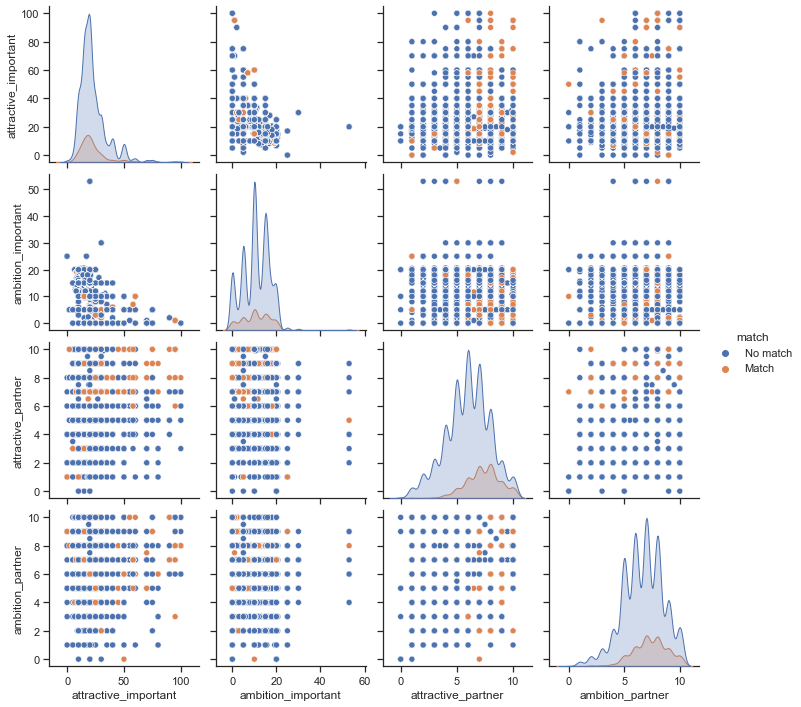

In [173]:
# What do people find important? Is this related to the outcome (match / no match)?
subset = ['attractive_important','ambition_important','attractive_partner','ambition_partner']
X_sub=X[subset].copy(deep=True) # Deep copy is overkill but avoids some warnings
X_sub['match'] = [classes[int(x)] for x in y] 
sns.set(style="ticks")
sns.pairplot(X_sub, hue="match");

## Part 1: Preprocessing

### Question 1.1: Simple pipeline (3 points)
Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a classifier:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Remove missing values by replace missing values with the mean value for that feature
    
**Note:** this function should not internally use any variables that are not passed as arguments (e.g. categorical columns must be derived from `X`, not by using the global `categorical` variable).

In [174]:
# Implement
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

def simple_pipeline(X, clf):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    X -- The training data
    clf -- any scikit-learn classifier
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    return Pipeline(steps=[('preprocess', make_column_transformer((make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore')), X.select_dtypes(include=["category"]).columns.tolist()), (make_pipeline(SimpleImputer(strategy='mean')),X.select_dtypes(exclude=["category"]).columns.tolist()))), ('classifier', clf)])

#### Sanity check
To be correct, this pipeline should be able to fit any classifier without error. Run this code to do a sanity check.

In [176]:
from sklearn.tree import DecisionTreeClassifier
simple_pipeline(X, DecisionTreeClassifier()).fit(X,y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'race', 'race_o',
                                                   'samerace', 'field']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                   

### Question 1.2: Feature count (1 point)
How many features are being constructed by this pipeline (i.e., on how many features is the classifier trained)?

In [177]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_2 = 287

### Question 1.3: Scaling (3 points)
First, implement a function `scale_feature` which performs scaling on a given numeric feature, and returns the scaled results.

In [178]:
def scale_feature(X, scaler, feature):
    """ Scale numerical feature 'feature' of data 'X' with scaler 'scaler'
    
    X -- training data
    scaler -- a scikit-learn transformer (e.g. StandardScaler)
    feature -- the feature of which to return the transformed results
    
    returns:
     a list or 1D numpy array with the scaled values
    """
    scaled_X = X[feature].copy(deep=True)
    scaled_X = np.reshape(scaled_X.values,(-1,1))
    scaled_X_ = scaler.fit_transform(scaled_X)
    scaled_X_= np.reshape(scaled_X_,(len(scaled_X_)))
    print(scaled_X_)
    return(scaled_X_)
    

Second, implement a function `plot_1_3` that plots the scaled values of the 'age'
feature, scaled with three different scalers: power transform, min-max scaling,
and standard scaling. You can use the default settings of the sklearn scalers. 

For the plotting, use the `plot_value_counts` function below, which uses your `scale_feature` function.

**Note:** Getting a plot output does not guarantee that your function implementation is correct. Interpret whether the values make sense.

In [179]:
from collections import Counter

def plot_value_counts(X, scalers, feature):
    """ Plots the counts of scaled feature values of the given feature using the given scalers
    It will simply ignore all missing values.
      
    X -- training data
    scalers -- an array of sklearn scaling transformers
    feature -- the name of the feature to be scaled and plotted. Must be a string
    """
    for scaler in scalers:
        scaled_values = scale_feature(X, scaler, feature)
        non_nan = [v for v in scaled_values if not np.isnan(v)]
        value_counts = Counter(non_nan)
        ax = sns.scatterplot(x=value_counts.keys(), y=value_counts.values(), label=scaler.__class__.__name__)
    ax.set_xlabel("scaled value")
    ax.set_ylabel("count")
    ax.set_title("number of occurrences of each value after scaling")

[-1.85671133 -1.85671133 -1.85671133 ... -0.28281369 -0.28281369
 -0.28281369]
[0.08108108 0.08108108 0.08108108 ... 0.18918919 0.18918919 0.18918919]
[-1.50255347 -1.50255347 -1.50255347 ... -0.38102059 -0.38102059
 -0.38102059]


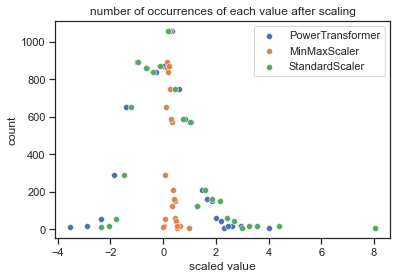

In [180]:
# Implement
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def plot_1_3(X):
    """ Plots the scaled values of the 'age' feature, scaled with three different 
    scalers: power transform, min-max scaling, and standard scaling.
    """
    scalers = [PowerTransformer(),MinMaxScaler(),StandardScaler()]
    plot_value_counts(X,scalers,'age')

plot_1_3(X)

### Question 1.4: Is scaling useful? (5 points)
First, implement a function `flexible_pipeline`: an extension of your earlier pipeline which also allows you to add a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling should be applied.

In [181]:
# Implement
from sklearn.preprocessing import StandardScaler
def flexible_pipeline(X, clf, scaler=StandardScaler()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The training data
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    if(scaler!=None):
        
        
        return Pipeline(steps=[('preprocess', make_column_transformer((make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore')), X.select_dtypes(include=["category"]).columns.tolist()), (make_pipeline(SimpleImputer(strategy='mean'),scaler), X.select_dtypes(exclude=["category"]).columns.tolist()))), ('classifier', clf)])                          
    else:
        
        return Pipeline(steps=[('preprocess', make_column_transformer((make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore')), X.select_dtypes(include=["category"]).columns.tolist()), (make_pipeline(SimpleImputer(strategy='mean')),X.select_dtypes(exclude=["category"]).columns.tolist()))), ('classifier', clf)])                          
        

In [182]:
# Sanity check
flexible_pipeline(X, DecisionTreeClassifier(), scaler=StandardScaler()).fit(X,y)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'race', 'race_o',
                                                   'samerace', 'field']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                     

Second, implement a function `plot_1_4` which plots a heatmap comparing several combinations of scaling methods and classifiers:
* As classifiers, the following algorithms in their default hyperparameters settings: 
    * SVM with RBF kernel
    * Random Forest
* As options, the following feature scaling options in their default settings:
    * No scaling
    * Standard scaling
    * PowerTransformer
* In all cases, use OneHotEncoder with `sparse=False` and `handle_unknown='ignore'`

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

In [183]:
### Helper plotting function. Do not change.
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of shape (#rows, #columns) of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")

In [184]:
def heatmap(columns, rows, scores, xlabel=None, ylabel=None):
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

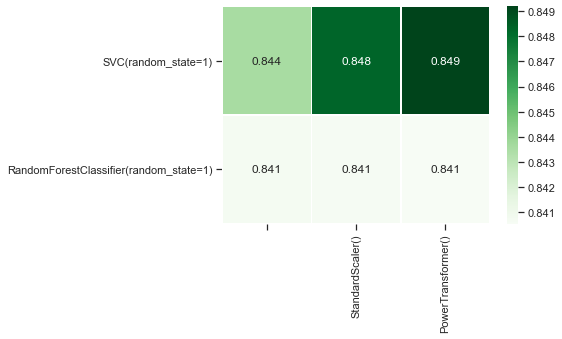

In [185]:
# Implement
from sklearn.metrics import roc_auc_score
import numpy 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def plot_1_4(X, y):
    """ Evaluates 2 classifiers together with 3 types of scaling. See description above.
    """
    score_list = []
    kfold = KFold(n_splits=3, random_state=1, shuffle=True)
    models = [SVC(kernel='rbf',random_state=1),RandomForestClassifier(random_state=1)]
    scalers =[None,StandardScaler(),PowerTransformer()]
    for m in models:
        for s in scalers:
            pipe = flexible_pipeline(X,m,scaler=s)
            scores = cross_val_score(pipe, X, y,cv=kfold,scoring='roc_auc')
            #print("Cross validation score for {}: {:.3f}".format(m.__class__.__name__, scores.mean()))
            score_list.append(scores.mean())
    score_list = numpy.array(score_list)
    score_list = numpy.reshape(score_list,(2,3))
    heatmap(scalers,models,numpy.array(score_list))

plot_1_4(X,y)

### Question 1.5: Interpretation (2 point)
Interpret the heatmap of Question 1.4. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': Scaling or not scaling makes no difference for any of the classifiers.
- 'B': Scaling is very important for both classifiers.
- 'C': Scaling is important for SVMs, but not needed for Random Forests.
- 'D': The default SVM with the right scaling technique performs slightly better than the default Random Forest.
- 'E': The power transformer is much better than other techniques on this dataset because many features have a power law distribution (performance difference is more than 1%).
- 'F': The power transformer about equally good as the standard scaler (performance difference is less than 1%)
- 'G': No answer

In [186]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_5 = 'C,D,F'

### Question 1.6: Grid search (2 points)

Perform a grid search for the SVM classifier. Range `C` on a log scale from 0.1 to 1000 (5 values), and `gamma` from 1e-4 to 1 (5 values).
Scale the data using standard scaling and use one-hot-encoding before passing the data to the SVM, and make sure that there is no data leakage. 
I.e. the test data must never be given to the preprocessings steps.

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation (more folds would be better, this is to save time). 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

Implement a function `plot_1_6` which plots a heatmap comparing the scores for all values of `C` and `gamma`. You can use the same heatmap function as before.

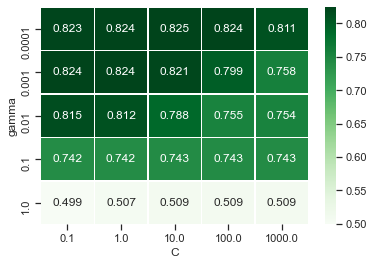

In [187]:
# Implement
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
def plot_1_6(X, y):
    """ Plots a heatmap for a grid search varying the C and gamma values for a scaled SVM
    """
    grid_svm = {'classifier__C': np.logspace(-1, 3, num=5),
                'classifier__gamma': np.logspace(-4, 0, num=5)}
    pipe_svm = flexible_pipeline(X,SVC(),StandardScaler())
    svm_res = GridSearchCV(pipe_svm, grid_svm, n_jobs=-1,cv=5,scoring='roc_auc').fit(X, y)
    
    scores = svm_res.cv_results_['mean_test_score'].reshape(grid_svm['classifier__C'].size,
                                                            grid_svm['classifier__gamma'].size).T
    
    heatmap(grid_svm['classifier__C'],grid_svm['classifier__gamma'],scores,xlabel="C",ylabel="gamma")

plot_1_6(X, y)

## Part 2: Feature importance
In this part, we verify which features are most important to include in our models. In addition, we will check whether it would be interesting to build different models, with different sets of features, for different types of people.






### Question 2.1: Specialized models (2 points)
Implement a function `fit_by_feature` that does the following: 
* Filter the input data by field of occupation (e.g. 'law' or 'engineering').
* Fit your `flexible_pipeline`, without feature scaling and with a RandomForest classifier (1000 trees, 10% for max_features, random state 0) on the filtered input data.
* Return the trained model



In [188]:
# Implement
def fit_by_feature(X, y, field=''):
    """ Returns a random forest model trained on data filtered by field of occupation. See detailed description above.
    Keyword arguments:
    X, y -- The input data
    field -- The field of occupation to filter on, e.g. 'engineering' or 'law'. Must be a string. 
    """
    #y_filtered = pd.Series()
    if(field!=''):
        X_filtered = X[X['field'] == field]
        index_fil = X[X['field'] == field].index
        y_filtered = y.loc[index_fil].copy()
    else:
        X_filtered = X
        y_filtered = y
   
    pipe = flexible_pipeline(X_filtered, RandomForestClassifier(n_estimators=1000,max_features=0.1,random_state=0),None).fit(X_filtered,y_filtered)
    return pipe

In [189]:
# Sanity check
fit_by_feature(X, y, field='engineering')

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'race', 'race_o',
                                                   'samerace', 'field']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                   

### Question 2.2: Cross-validation (3 points)
Implement a function 'evaluate_by_feature' that evaluates the model trained by 
'fit_by_feature' using 5-fold stratified cross-validation and AUC. Then, use it to evaluate 3 models:
- The model trained with all the data
- The model trained for participants from the field "engineering"
- The model trained for participants from the field "law"

For all models, use your `fit_by_feature` function. For the cross-validation, 
use shuffling and random state 0.

Note: You can't use `cross_val_score` here, you need to implement a simple
cross-validation loop around 'fit_by_feature' yourself.  
Note 2: Technically, since the same people occur multiple times in this dataset,
grouped cross-validation should be used. However, since the ID of these people
is not in the dataset, there is no way to do this and you can ignore this.

In [190]:
from sklearn.model_selection import StratifiedKFold
def evaluate_by_feature(X, y, field='', fitter=fit_by_feature):
    """ Returns the mean AUC score of the given model based on stratified 5-fold cross-validation.
    Keyword arguments:
    X, y -- The input data
    field -- The field of occupation to filter on, e.g. 'engineering' or 'law'. Must be a string. 
    fitter -- The model to be evaluated. Must adhere to the interface of the fit_by_feature(X, y, field) function.
    """
    scores = []
    
    Xx_train, Xx_test, yy_train, yy_test = train_test_split(X, y,random_state=1)
    
    if(field!=''):
        Xx_test = Xx_test[Xx_test['field'] == field]
        index = Xx_test[Xx_test['field'] == field].index
        yy_test = yy_test.loc[index].copy()
    else:
        Xx_test = Xx_test
        yy_test = yy_test
    
    sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    sss.get_n_splits(Xx_train, yy_train)
    
    
    for train_index, test_index in sss.split(Xx_train, yy_train):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe = fit_by_feature(X_train,y_train,field)
        scores.append(roc_auc_score(yy_test,pipe.predict(Xx_test)))
    if(field==''):
        print("Mean scores for the Model",np.mean(scores))
    else:
        print("Mean scores for the Model with field",field,np.mean(scores))
    
    

evaluate_by_feature(X,y,field='')
#The data has 127 instances of engineers and 607 instances of law. So the data might not be enough to build a prediction model for engineers    
evaluate_by_feature(X,y,field='engineering')
evaluate_by_feature(X,y,field='law')

Mean scores for the Model 0.8377672092084403
Mean scores for the Model with field engineering 0.6962962962962963
Mean scores for the Model with field law 0.8950649350649351


Interpret the AUC scores. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces-valued, e.g. "A,B,C"

*   'A': The models all have very similar performance (less that 5% difference)
*   'B': It is harder to predict a good match for engineers than for lawyers, based on only the data available for that field.
*   'C': It is harder to predict a good match for lawyers than for engineers, based on only the data available for that field.
*   'D': Based on these results, it's not worth training per-field models, it's best to use all available data in one model.
*   'E': No answer

In [191]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_2_2 = 'B,D'

### Question 2.3: Feature importance (3 points)
Implement a function `plot_2_3` that does the following:  
* Call your `fit_by_feature` function to train a pipeline on the filtered input data with fields "engineering", "law" and "film".
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Plot the model-based feature importances using the plotting function `plot_importances` below.

*Notes*

* *Remember that the categorical features were encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`).*

In [192]:
# Plotting function. Do not edit.
def plot_importances(importance, feature_names, top_k=20, title=""):
    """ Simple bar chart plottinh feature importances
    Keyword arguments:
    importance -- The feature importances 
    feature_names -- The original features names in their original order
    top_k -- How many features to plot
    """
    # Trees
    sorted_idx = importance.argsort()[-top_k:]
    fig, ax = plt.subplots(figsize=(5, 5))
    y_ticks = np.arange(0, top_k)
    ax.barh(y_ticks, importance[sorted_idx])
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(title)

    fig.tight_layout()
    plt.show()

<ipython-input-192-33fcc10bb157>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


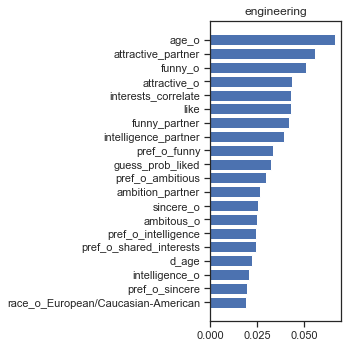

<ipython-input-192-33fcc10bb157>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


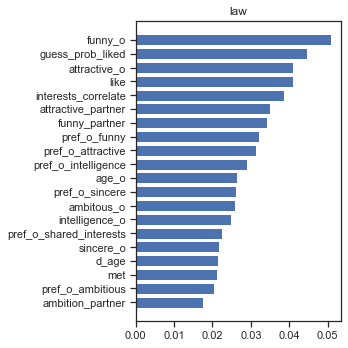

<ipython-input-192-33fcc10bb157>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


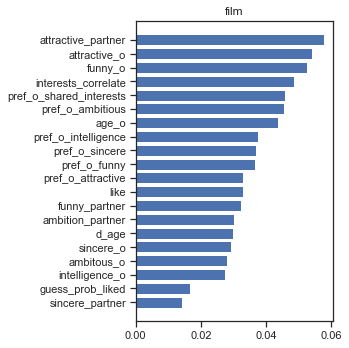

In [193]:
# Implement
def plot_2_3(X, y, field=''):
    """ Returns a plot of the most important features, where data is filtered by field. See detailed description above.
    """
    field_list = ['engineering','law','film']
    for f in field_list:
        pipe = fit_by_feature(X,y,f)
        fi = pipe.steps[0][1].named_transformers_['pipeline-1'][1].get_feature_names(input_features = categorical)
        new_names = list(fi)
        num_feat = pipe.steps[0][1].transformers[1][2]
        new_names.extend(num_feat)
        feature_importance_df = np.array(pipe.named_steps.classifier.feature_importances_)
        plot_importances(feature_importance_df, np.array(new_names), top_k=20, title=f)
    
plot_2_3(X, y, field='')


### Question 2.4: Interpretation (2 points)

Interpret the previous results of Question 2. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': The matches for engineers, lawyers, and people in the film industry are decided by the exact same features.
- 'B': Matches for engineers are strongly influenced by age, while this is much less the case for lawyers and people in the film industry.
- 'C': Most matches depend strongly on whether the person was considered funny (funny_o) and the partner was considered funny (funny_partner), irrespective of profession.
- 'D': There are significant differences in the feature importances based on field, but this does not translate into better per-field models.
- 'E': No answer

In [ ]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_2_4 = 'C'

## Part 3: Threshold calibration

### Question 3.1: Tuning random forests (2 points)
Use a grid search to optimize the RandomForest pipeline from question 2.1. Vary the number of trees from 100 to 1500 (at least 4 values) and set `max_features` to either
0.05, 0.1, or 'auto' (sqrt(p)). Evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Plot the results in a heatmap in function `plot_3_1`.

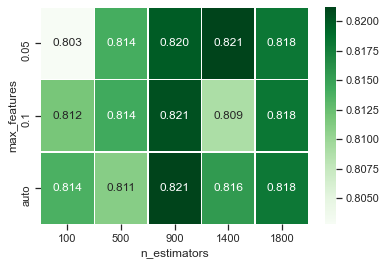

In [194]:
#Implement
def plot_3_1(X, y):
    """ See detailed description above.
    """
    grid_rf = {'classifier__n_estimators': (100,500,900,1400,1800),
                'classifier__max_features': (0.05,0.1,'auto')}
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(random_state=1))
    rf_res = GridSearchCV(pipe_rf, grid_rf, n_jobs=-1,cv=3,scoring='roc_auc').fit(X, y)
    
    scores = rf_res.cv_results_['mean_test_score'].reshape(5,3).T
    heatmap(grid_rf['classifier__n_estimators'],grid_rf['classifier__max_features'],scores,xlabel="n_estimators",ylabel="max_features")

plot_3_1(X,y)
    

### Question 3.2: ROC curve (3 points)
Implement a function `plot_3_2` that plots the ROC curve for the Random Forest pipeline with `n_estimators=1000`.
Also indicate the point on the curve that corresponds to the 0.5 probability decision threshold and mentioned it on the plot legend.

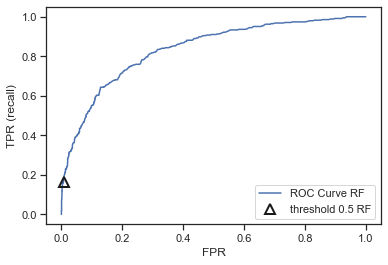

In [195]:
#Implement
from sklearn.metrics import roc_curve
def plot_3_2(X, y):
    """ See detailed description above.
    """
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000))
    pipe_rf.fit(X_train,y_train)
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pipe_rf.predict_proba(X_test)[:, 1])

    plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
    plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);

plot_3_2(X,y)
#lower the threshold to get a better recall(TPR), (not miss any good match)

### Question 3.3: Threshold calibration (3 points)
Calibrate your model to get a higher recall. What would be the optimal decision threshold (approximately) assuming that a false negative (missing a good match) is twice as bad as a false positive (going on a date with someone who is not a good match)? Be careful that the dataset is imbalanced, so this must be taken into account. The goal is to find the threshold with the lowest actual cost (taking the usual ratio of positive and negative labels into account). Your results may vary slightly. The grade will depend on the distance to the actual optimum (within a tolerance).

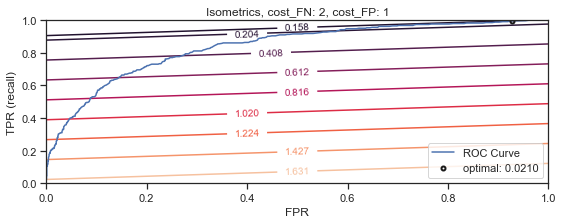

In [199]:
from sklearn.metrics import roc_curve

# Reusing code for the lecture notebook
# Cost function, give the cost for FN and FP
def cost(fpr, tpr, cost_FN, cost_FP, ratio_P):
    return fpr * cost_FP * ratio_P + (1 - tpr) * (1 - ratio_P) * cost_FN;

def plot_isometrics(X,y,c_FN=2, c_FP=1):
    # Build the ROC curve for the trained model
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000))
    pipe_rf.fit(X_train,y_train)
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pipe_rf.predict_proba(X_test)[:, 1])
    #fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(Xs_test))

    # Compute costs
    ratio_P = len(y_test[y_test==1]) / len(y_test)
    costs = [cost(fpr_rf[x],tpr_rf[x],c_FN,c_FP, ratio_P) for x in range(len(thresholds_rf))]
    
    # Get optimal cost and threshold
    min_cost = np.min(costs)
    min_thres = np.argmin(costs)
    min_thres_val = thresholds_rf[np.argmin(costs)]

    # plot contours
    x = np.arange(0.0, 1.1, 0.1)
    y = np.arange(0.0, 1.1, 0.1)
    XX, YY = np.meshgrid(x, y)
    costs = [cost(f, t, c_FN, c_FP, ratio_P) for f, t in zip(XX,YY)]

    # plot all together
    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    plt.plot(fpr_rf, tpr_rf, label="ROC Curve")
    levels = np.linspace(np.array(costs).min(), np.array(costs).max(), 10)
    levels = np.sort(np.append(levels, min_cost))
    CS = plt.contour(XX, YY, costs, levels)
    plt.clabel(CS, inline=1, fontsize=10)

    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero:
    plt.plot(fpr_rf[min_thres], tpr_rf[min_thres], 'o', markersize=4,
             label="optimal: {:.4f}".format(min_thres_val), fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);
    plt.title("Isometrics, cost_FN: {}, cost_FP: {}".format(c_FN, c_FP))
    plt.show()
    
plot_isometrics(X,y)

In [200]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
def results(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000))
    pipe_rf.fit(X_train,y_train)
    y_pred = pipe_rf.predict(X_test)

    # Get the scores by comparing the predictions y_pred with the ground truth y_test
    print("Values before setting the threshold :")
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
    print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    
results(X,y)

Values before setting the threshold :
Accuracy: 0.860
Precision: 0.871
Recall: 0.177
F1 score: 0.294
AUC: 0.586


In [201]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
def results_optimize(X,y):
    
   
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000))
    pipe_rf.fit(X_train,y_train)
    y_pred = pipe_rf.predict(X_test)
    y_pred = (pipe_rf.predict_proba(X_test)[:, 1] >= -0.02).astype(int)
    # Get the scores by comparing the predictions y_pred with the ground truth y_test
    print("Values after setting the threshold to 0.0260:")
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
    print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))
results_optimize(X,y)

Values after setting the threshold to 0.0260:
Accuracy: 0.165
Precision: 0.165
Recall: 1.000
F1 score: 0.283
AUC: 0.500


In [ ]:
# Fill in the correct answer, should be a float. Don't change the name of the variable
q_3_3 = 0.02

## Part 4: Algoritmic bias
Check whether there is any algorithmic bias in the predictions.

### Question 4.1 Racial bias (3 points)
* Use the same RandomForest pipeline with 1000 trees and `max_features=0.1`
* Use 3-fold stratified cross validation and return the predictions for every fold
* Separate the test set predictions into different groups depending on the feature 'race', and report the ROC AUC for each group
* Implement a function `plot_4_1` which returns a visualization of these results (e.g. a bar chart)

[0.7757080329557158, 0.7454958965666585, 0.774486921529175, 0.7895226466655036, 0.8446115288220551]
['Asian/Pacific Islander/Asian-American', 'European/Caucasian-American', 'Other', 'Latino/Hispanic American', 'Black/African American']
{0.7757080329557158: 'Asian/Pacific Islander/Asian-American', 0.7454958965666585: 'European/Caucasian-American', 0.774486921529175: 'Other', 0.7895226466655036: 'Latino/Hispanic American', 0.8446115288220551: 'Black/African American'}


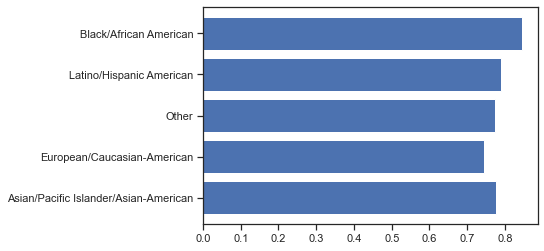

In [202]:
#Implement
from sklearn.model_selection import cross_val_predict
def plot_4_1(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000,max_features=0.1))
    
    y_pred = cross_val_predict(pipe_rf, X, y,cv=3)
    
    y_pred = pd.Series(y_pred)
    
    score_list = list()
    
    race_list =['Asian/Pacific Islander/Asian-American','European/Caucasian-American','Other','Latino/Hispanic American','Black/African American']
    for i in race_list:
        X_i = X[X['race'] == i]
        index_i = X[X['race'] == i].index
        y_i = y.loc[index_i].copy()
        y_pred_i = y_pred.loc[index_i].copy()
        roc_score = roc_auc_score(y_pred_i,y_i)
        score_list.append(roc_score)
    print(score_list)
    print(race_list)
    res = dict(zip(score_list, race_list)) 
    print(res)
    plt.barh((np.array(race_list)),(np.array(score_list)))
    plt.show()

        
plot_4_1(X,y)

### Question 4.2 (3 points)
* Implement a function `plot_4_2` where you weight the samples (instances) with a weight inversely proportional to their frequency and then visualise the results in the same way as in question 4.1 (as a bar chart).
* Interpret the results and explain them in `answer_q_4_2` (max 400 characters).

{0.7939391723936249: 'Asian/Pacific Islander/Asian-American', 0.751078676951068: 'European/Caucasian-American', 0.8133466135458167: 'Other', 0.8223357772346886: 'Latino/Hispanic American', 0.8586235489220564: 'Black/African American'}


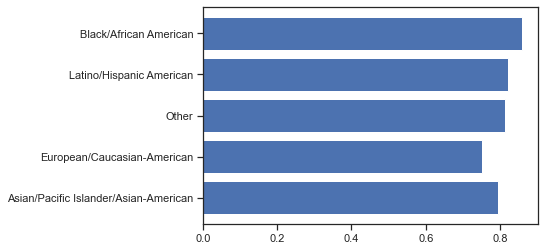

In [203]:
#Implement
def plot_4_2(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pipe_rf = flexible_pipeline(X,RandomForestClassifier(n_estimators=1000,max_features=0.1))
    
    sample_weights = []
    #create a list of sample_weights based on frequency
    for i in range(len(X)) :  
        if(X.loc[i, "race"] == 'Asian/Pacific Islander/Asian-American'):
            sample_weights.append(1/1982)
        elif(X.loc[i, "race"] == 'European/Caucasian-American'):
            sample_weights.append(1/4727)
        elif(X.loc[i, "race"] == 'Other'):
            sample_weights.append(1/522)
        elif(X.loc[i, "race"] == 'Latino/Hispanic American'):
            sample_weights.append(1/664)
        elif(X.loc[i, "race"] == 'Black/African American'):
            sample_weights.append(1/420)
        else:
             sample_weights.append(0)
    
    
    y_pred = cross_val_predict(pipe_rf,X,y,cv=3,fit_params={"classifier__sample_weight":sample_weights})
    
    y_pred = pd.Series(y_pred)
    score_list = list()
    
    race_list =['Asian/Pacific Islander/Asian-American','European/Caucasian-American','Other','Latino/Hispanic American','Black/African American']
    for i in race_list:
        X_i = X[X['race'] == i]
        index_i = X[X['race'] == i].index
        y_i = y.loc[index_i].copy()
        y_pred_i = y_pred.loc[index_i].copy()
        roc_score = roc_auc_score(y_pred_i,y_i)
        score_list.append(roc_score)
    res = dict(zip(score_list, race_list)) 
    print(res)
    plt.barh((np.array(race_list)),(np.array(score_list)))
    plt.show()
    
plot_4_2(X,y)

In [204]:
answer_q_4_2 = """
               For 63 instances out of 8378 instances, there are no race assigned. So for those instances, weight of zero is assigned.
               There no acute difference in the score after weighing and before weighing, but there are a few changes in the values.
               After weighing the score of the 'Latino/Hispanic American' and 'Others' are a bit higher from the scores. Nevertheless,
               there are no serious differences observed.
               
               """
print("Answer is {} characters long".format(len(answer_q_4_2)))

Answer is 493 characters long


In [205]:
print(time.time()-start_time)

2212.402177095413
